# Tarea 1: Algoritmos de Descenso Estocástico

Implementación de las versiones estocásticas de algoritmos de descenso de gradiente.

## Objetivo

Dada una serie de tiempo donde el vector $\mathbf{y}$ contine los valores de dicha serie y el vector $\mathbf{x}$ representa los índices (posiciones) de cada valor, con  $\mathbf{y} \in R^n$ y  $\mathbf{y} \in R^n$, resolver el problema de Regresión:

> $
\begin{aligned}
\underset{\mathbf{\alpha}, \mathbf{\mu}}{\operatorname{min}} J(\alpha, \mu) = \frac{1}{2}|| \alpha \Phi (\mathbf{x}) - \mathbf{y}||_2 ^2
\end{aligned}
$

donde:

> $
\begin{aligned}
\Phi^T = [\phi_1, \phi_2, ..., \phi_m]
\end{aligned}
$,

con:

> $
\begin{aligned}
\phi_{j} = \textrm{exp}\left( \frac{1}{2 \sigma^2} (\mathbf{x} - \mu_j)^2 \right) 
\end{aligned}
$;

- $\mu$: es un vector de dimensión $m$ que indica la posición central de cada una de las $j$-ésimas funciones base $\phi_j$.
- $\alpha$: es un vector de dimensión $m$ cuyas entradas representan la contribución de cada una de las $j$-ésimas funciones base $\phi_j$ para aproximar óptimamente $\mathbf{y}$.
- $\sigma$: es una constante que determina el ancho de cada función base.

## Problemática
Como estudio de caso se propone la siguiente serie de tiempo con $n=1400$ posiciones, donde $\mathbf{y}$ corresponde al valor (de apertura) en dólares (USD) de la criptomoneda ether (**ETH**) a lo largo de 1400 horas (datos obtenidos el día 7 de febrero del 2021, 19:00 horas).


Los datos fueron obtenidos de la página [cryptocompare](https://www.cryptocompare.com/) a través de la librería `cryptocompare` de python y posteriormente fueron guardados en un archivo `pickle`.


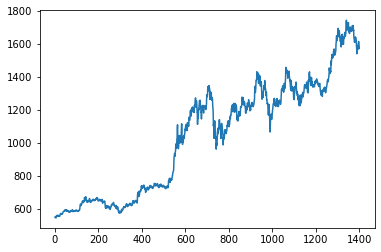

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_eth = pd.read_pickle('../ETH_1400_hours_07022021.pkl')

y = df_eth['open']
x = np.arange(len(y))

plt.plot(x, y, label="sample data")

## Estrategia de solución:

Optimizar los $m$ valores de los vectores $\mu$ y $\alpha$, con $\sigma$ constante, para minimizar la función de costo $J(\alpha, \mu)$, de tal manera que la suma de $m$ funciones base (curvas) se ajuste de manera óptima a los datos observados, $\mathbf{y}$, de la serie de tiempo. 

> $
\begin{aligned}
\underset{\alpha, \mu}{\operatorname{min}} J(\alpha, \mu) = \frac{1}{2n}\sum_{i=1}^n (\alpha \Phi(x_i) - y_i)^2
\end{aligned}
$

> $
\begin{aligned}
\underset{\alpha, \mu}{\operatorname{min}} J(\alpha, \mu) =  \frac{1}{2n}\sum_{i=1}^n \left( \sum_{j=1}^m\alpha_j\phi_j(x_i) - y_i \right)^2
\end{aligned}
$


**Para ello se propone lo siguiente:**
1. **Iniciar con** un vector $\mu_0$ con $m$ medias iniciales, un vector $\alpha_0$ con $m$ valores de amplitud iniciales, y un valor $\sigma$ constante.
    > - El valor de $\sigma$ se establece mediante $\sigma = n / (2m)$, donde $n$ es el número de posiciones en la serie de tiempo, y $m$ es el número de funciones base a utilizar.
    > - Los $m$ valores de $\mu_0$ son elegidos de forma aleatoria en el rango de 1 a $n$.
    > - $\alpha_0$ es un vector de unos de tamaño $m$.
    
2. **Iterar hasta convergencia**; en cada iteración $t$:
- a) Resolver aproximadamente:
> $
\begin{aligned}
\alpha_{t+1} = \underset{\mathbf{\alpha}}{\operatorname{min}} J(\alpha_t, \mu_t)
\end{aligned}
$, con $\mu$ fija.  

> Para lo cual se propone utilizar la pseudoinversa de **Moore-Penrose**: 
> $\alpha^*_t = (\Phi^T \Phi)^{-1} \Phi^T \mathbf{y}$

- b) Resolver aproximadamente:
> $
\begin{aligned}
\mu_{t+1} = \underset{\mathbf{\mu}}{\operatorname{min}} J(\alpha_{t+1}, \mu_t)
\end{aligned}
$, con $\alpha$ fija. 

> Para lo cual se propone utilizar alguna de las **variantes del algoritmo de descenso de gradiente** en su versión estocástica, con:

> $
\begin{aligned}
\nabla J(\mu)^T = \left[\frac{\partial J}{\partial \mu_1}, \frac{\partial J}{\partial \mu_2}, ..., \frac{\partial J}{\partial \mu_m} \right]
\end{aligned}
$,

> $
\begin{aligned}
\frac{\partial J(\mu)}{\partial \mu_j} = \frac{1}{n}\sum_{i=1}^n ( \Phi(x_i) - y_i) \cdot \frac{\partial \Phi}{\partial \mu_j}
% \underset{\alpha, \mu}{\operatorname{min}} J(\alpha, \mu) = \frac{1}{2n}\sum_{i=1}^n ( \Phi(x_i) - y_i)^2
\end{aligned}
$


    

## Implementación

### Funciones para el cálculo del gradiente

Definición de las **funciones necesarias** para el cálculo del gradiente.

In [2]:
from typing import Callable, Tuple

def phi_j(x: np.array, mu_j: float, 
          sig: float) -> np.array:
    ''' Función base phi_j '''
    phi = np.exp( - (x - mu_j)**2 / (2 * sig**2))
    return phi

def partial_phi_mu(x: np.array, mu_j: float, 
          sig: float) -> np.array:
    ''' Derivada parcial de phi_j con 
        respecto a mu_j (dPhi/dmuj) '''
    phi = phi_j(x, mu_j, sig)
    part_phi_mu = - ((x - mu_j) / sig**2)  * phi
    return part_phi_mu


def PHI(x: np.array, mus: np.array, 
        sig: float) -> np.array:
    ''' Vector con m phi_j funciones base (Phi) '''
    PHI = []
    for mu_j in mus:
        PHI.append(phi_j(x, mu_j, sig))
    return np.array(PHI)


def J(x: np.array, y: np.array, 
      mus: np.array) -> float:
    ''' Función de costo (J) '''
    y_hat = PHI(x, mu)
    residual = y - y_hat.sum()
    cost = (residual).dot(residual)
    return cost


def alpha_ast(x: np.array, y: np.array, 
      mus: np.array, sig: float) -> np.array:
    ''' Calcula los valores óptimos de alphas usando
        la pseudo inversa de Moore-Penrose '''
    PHI_ = PHI(x, mus, sig).T
    alphas_ast = np.linalg.pinv(PHI_).dot(y)
    return alphas_ast


def grad_J(x: np.array, y: np.array, 
           mus: np.array, alphas: np.array,
           sig: float) -> np.array:
    ''' Gradiente de la función de costo (nablaJ) '''
    nablaJ = []
    y_hat = alphas.dot( PHI(x, mus, sig) )
    error = y - y_hat
    dJ_df = error
    
    for mu_j in mus:
        dp_dmu_j = partial_phi_mu(x, mu_j, sig)
        dJ_dmu_j = dJ_df.dot(dp_dmu_j)      
        nablaJ.append(dJ_dmu_j)
        
    return np.array(nablaJ)

### Funciones Miscelaneas

In [3]:
def graficar_resultados(parms_at_T: np.array, 
                        titulo: str) -> None:
    ''' Grafica de los resultados a diferentes 
        números de iteraciones.
    '''
    fig, ax = plt.subplots(2, 3, figsize=(15, 7))
    fig.suptitle(titulo, fontsize=15)
    for i, parms in enumerate(parms_at_T):
        mu_hat, a_hat = parms
        predict_y = np.array(a_hat).dot(PHI(x, mu_hat, sigma))
        
        # Gráfica de los datos originales y el modelo
        ax[0, i].plot(x, y, label='Datos')
        ax[0, i].plot(x, predict_y, c='red', 
                      label=r'Modelo $\alpha\Phi$')
        ax[0, i].legend()
        ax[0, i].set(title=f'n iters = {n_iters[i]}')
        
        # Gráfica mostrando las m curvas
        ax[1, i].plot(x, predict_y, c='black', 
                      linewidth=2, label=r'Modelo $\alpha\Phi$')
        for a, mu in zip(a_hat, mu_hat):
                phi =  a * phi_j(x, mu, sigma) 
                ax[1, i].plot(x, phi)
                ax[1, i].set_xlabel('índices')
                ax[1, i].legend()
    ax[0, 0].set_ylabel('Valor ETH (USD)')
    ax[1, 0].set_ylabel('Valor ETH (USD)')
    plt.plot()

### Parámetros generales

In [4]:
%%time
# Semilla para reproducir los resultados
np.random.seed(4)
# Número de funciones base (curvas)
m = 15
# Longitud de la serie de tiempo
n = len(x)
# Tamaño de sigma
sigma = n / (m*2)
# Valores iniciales de mu
mus = np.random.randint(0, n, size=m)
# Valores iniciales de alfa
alphas = np.ones(m)

# Parámetros para el cálculo del gradiente
grad_params = dict(
    mus = mus, 
    alphas = alphas,
    sig = sigma
)

# Número iteraciones para 3 reproducciones
n_iters = (10, 100, 1000)

CPU times: user 173 µs, sys: 44 µs, total: 217 µs
Wall time: 207 µs


## Algoritmos de Descenso de Gradiente

In [5]:
def GD(grad: Callable, grad_params: dict,
       x: np.array, y: np.array, 
       lr: float=0.1, n_iter: int=500
      ) -> Tuple:
    '''Batch Gradient Descent'''
    mus = grad_params['mus']
    alphas = grad_params['alphas']
    sig = grad_params['sig']
    
    for t in range(n_iter):
        # Alphas
        alphas = alpha_ast(x, y, mus, sig)
        # Gradiente para mus
        p = - grad(x, y, mus, alphas, sig)
        mus = mus + lr * p
        
    return mus, alphas





        
    
def AdaDelta(
        grad: Callable, grad_params: dict,
        x: np.array, y: np.array, 
        lr: float=0.1, n_iter: int=500,
        batch_size: int=100,
        eta: float=0.9
       ) -> Tuple:
    '''Descenso de Gradiente Adaptable (ADADELTA) '''
    mus = grad_params['mus']
    alphas = grad_params['alphas']
    sig = grad_params['sig']
    
    # Términos de AdaDelta
    epsilon = 1e-8
    G_t = np.zeros_like(mus)
    
    for t in range(n_iter):
        # Submuestreo
        smp_x, smp_y = stochastic_smpl(x, y, batch_size)
        # Alphas
        alphas = alpha_ast(smp_x, smp_y, mus, sig)
        
        # Gradiente para mus
        g_t = grad(smp_x, smp_y, mus, alphas, sig)
        #  G_t = eta * g_t**2 + (1 - eta) * G_t # Versión Material Apoyo
        G_t = eta * G_t + (1 - eta) * g_t**2 # Versión de bibliografía
        p_t = 1 / (np.sqrt(G_t) + epsilon) * g_t
        mus = mus - lr * p_t
        
    return mus, alphas


def ADAM(grad: Callable, grad_params: dict,
         x: np.array, y: np.array, 
         lr: float=0.1, n_iter: int=500,
         batch_size: int=100,
         eta_p: float=0.9, eta_v: float=0.999,
         nesterov: bool=False
        ) -> Tuple:
    ''' Descenso de Gradiente Adaptable (ADADELTA) '''
    mus = grad_params['mus']
    alphas = grad_params['alphas']
    sig = grad_params['sig']
    
    # Términos de AdaDelta
    epsilon = 1e-8
    p_t = np.zeros_like(mus)
    v_t = np.zeros_like(mus)
    eta_p_t = eta_p
    eta_v_t = eta_v
    lr_t = 0
    
    for t in range(1, n_iter + 1):
        # Submuestreo
        smp_x, smp_y = stochastic_smpl(x, y, batch_size)
        # Alphas
        alphas = alpha_ast(smp_x, smp_y, mus, sig)
        
        # Gradiente para mus
        # Si nesterov
        if nesterov:
            mus_tilde = mus - lr_t * p_t / (np.sqrt(v_t + epsilon))
            g_t = grad(smp_x, smp_y, mus_tilde, alphas, sig)
        else:
            g_t = grad(smp_x, smp_y, mus, alphas, sig)
        p_t = eta_p * p_t + (1 - eta_p) * g_t
        v_t = eta_v * v_t + (1 - eta_v) * g_t * g_t
        
        # Corrige el sesgo (implementación según la referencia)
        lr_t = lr * (np.sqrt(1 - eta_v_t) / (1 - eta_p_t))
        # Actualiza etas_t
        eta_p_t *= eta_p
        eta_v_t *= eta_v
        
        # Actualiza los parámetros
        mus = mus - lr_t * p_t / (np.sqrt(v_t + epsilon))

    return mus, alphas

CPU times: user 19.2 s, sys: 750 ms, total: 19.9 s
Wall time: 5.37 s


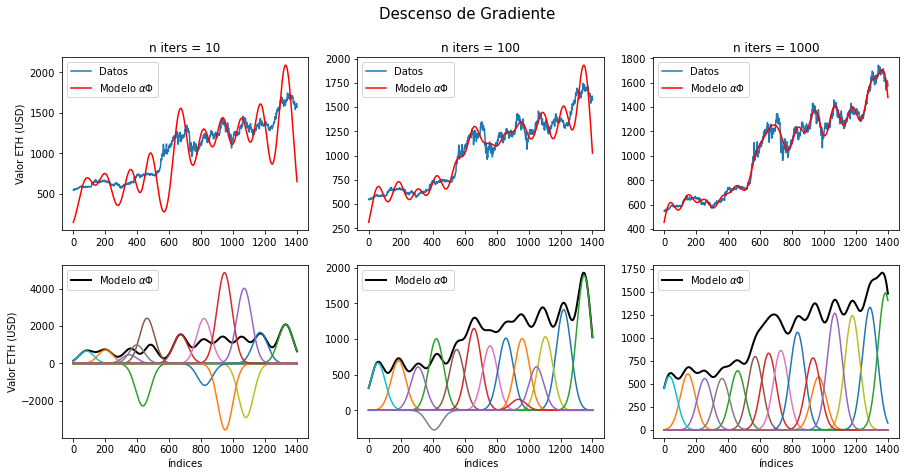

In [6]:
%%time

titulo = 'Descenso de Gradiente'
parms_at_T = []
for T in n_iters:
    mu_hat, a_hat = GD(grad = grad_J, 
                grad_params= grad_params,
                x=x, y=y, 
                lr=0.01, n_iter=T)
    parms_at_T.append((mu_hat, a_hat))


graficar_resultados(parms_at_T, titulo)

### Descenso de Gradiente Estocástico

In [ ]:
def stochastic_smpl(x: np.array, y: np.array, 
            batch_size: int=100) -> Tuple:
    '''Función para el muestreo estocástico'''
    
    n = len(x)
    smpIdx = np.random.randint(
                    low=0, high=n, 
                    size=batch_size)
    smp_x = x[smpIdx]
    smp_y = y[smpIdx]
    return smp_x, smp_y


def SGD(grad: Callable, grad_params: dict,
        x: np.array, y: np.array, 
        lr: float=0.1, n_iter: int=500,
        batch_size: int=100
       ) -> Tuple:
    ''' Descenso de Gradiente Estocástico'''
    
    mus = grad_params['mus']
    alphas = grad_params['alphas']
    sig = grad_params['sig']
    
    for t in range(n_iter):
        # Submuestreo
        smp_x, smp_y = stochastic_smpl(x, y, batch_size)
        # Alphas
        alphas = alpha_ast(smp_x, smp_y, mus, sig)
        # Gradiente para mus
        p_t = grad(smp_x, smp_y, mus, alphas, sig)
        mus = mus - lr * p_t
        
    return mus, alphas


CPU times: user 12.4 s, sys: 454 ms, total: 12.8 s
Wall time: 3.43 s


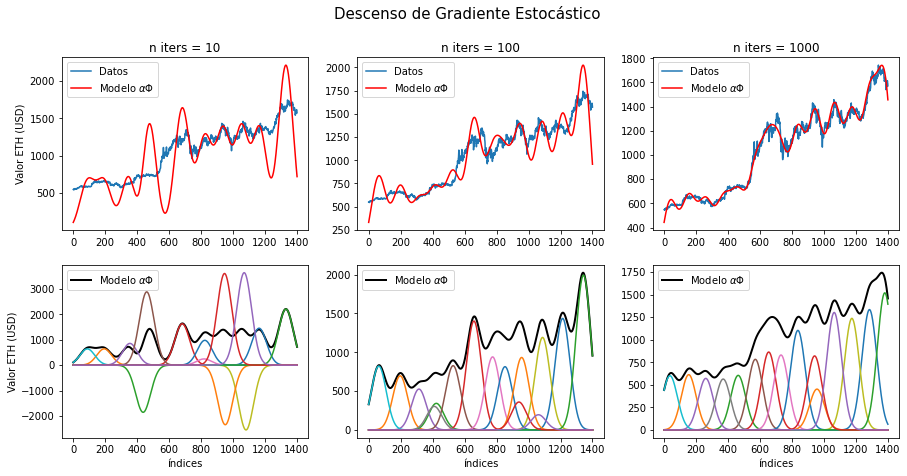

In [7]:
%%time

titulo = 'Descenso de Gradiente Estocástico'
parms_at_T = []
for T in n_iters:
    mu_hat, a_hat = SGD(grad = grad_J, 
            grad_params= grad_params,
            x=x, y=y, 
            batch_size=100,
            lr=0.1, n_iter=T)
    parms_at_T.append((mu_hat, a_hat))

# Graficas de los resultados
graficar_resultados(parms_at_T, titulo)

### Descenso de Gradiente con Momento de Nesterov

In [ ]:
def NesterovMGD(
        grad: Callable, grad_params: dict,
        x: np.array, y: np.array, 
        lr: float=0.1, n_iter: int=500,
        batch_size: int=100,
        eta: float=0.9
       ) -> Tuple:
    ''' Descenso de Gradiente con Momento de Nesterov'''
    mus = grad_params['mus']
    alphas = grad_params['alphas']
    sig = grad_params['sig']
    
    # Inicializa p_0 = 0
    p_t = np.zeros_like(mus)
    for t in range(n_iter):
        # Submuestreo
        smp_x, smp_y = stochastic_smpl(x, y, batch_size)
        # Alphas
        alphas = alpha_ast(smp_x, smp_y, mus, sig)
        
        # Gradiente para mus
        mus_tilde = mus + lr * p_t
        g_t = grad(smp_x, smp_y, mus_tilde, alphas, sig)
        p_t = g_t - eta * p_t
        mus = mus - lr * p_t
        
    return mus, alphas

CPU times: user 12.7 s, sys: 456 ms, total: 13.1 s
Wall time: 3.47 s


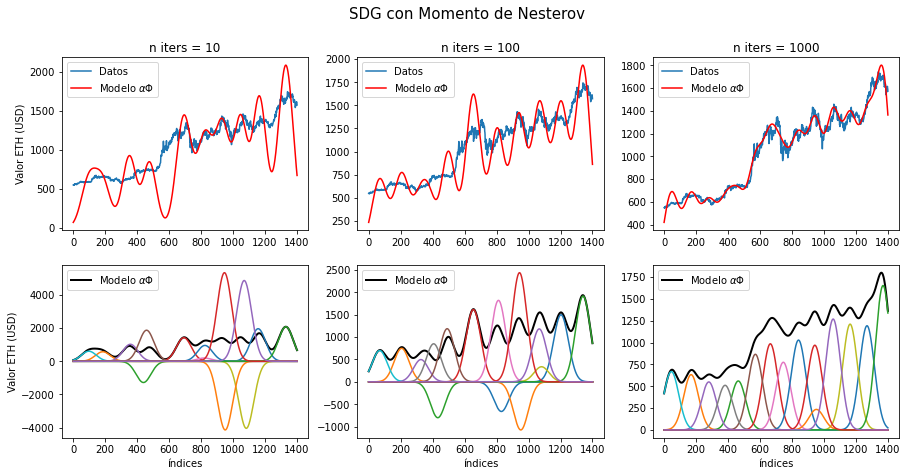

In [8]:
%%time

titulo = 'SDG con Momento de Nesterov'
parms_at_T = []
for T in n_iters:
    mu_hat, a_hat = NesterovMGD(grad = grad_J, 
            grad_params= grad_params,
            x=x, y=y, 
            batch_size=100,
            lr=0.1, n_iter=T)
    parms_at_T.append((mu_hat, a_hat))

# Graficas de los resultados
graficar_resultados(parms_at_T, titulo)

### AdaDelta

CPU times: user 12.7 s, sys: 456 ms, total: 13.2 s
Wall time: 3.54 s


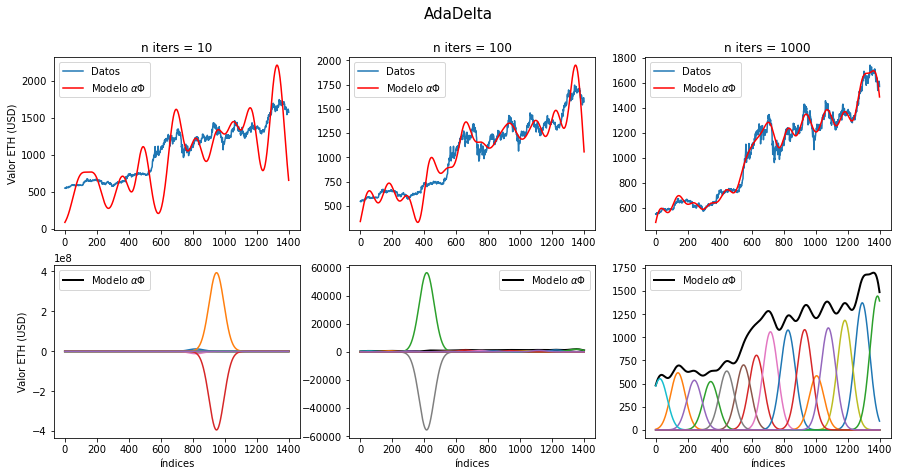

In [9]:
%%time

titulo = 'AdaDelta'
parms_at_T = []
for T in n_iters:
    mu_hat, a_hat = AdaDelta(grad = grad_J, 
            grad_params= grad_params,
            x=x, y=y, 
            batch_size=100,
            lr=0.95, n_iter=T)
    parms_at_T.append((mu_hat, a_hat))

# Graficas de los resultados
graficar_resultados(parms_at_T, titulo)

### ADAM

CPU times: user 11.9 s, sys: 376 ms, total: 12.3 s
Wall time: 3.22 s


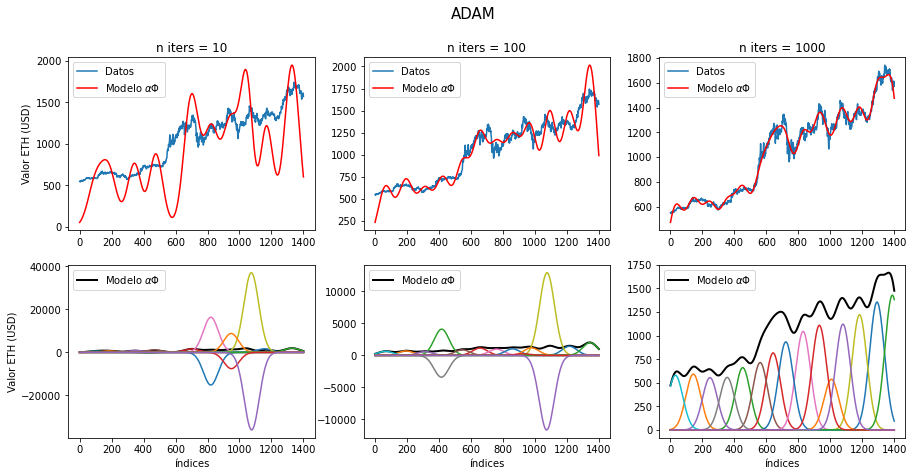

In [10]:
%%time

titulo = 'ADAM'
parms_at_T = []
for T in n_iters:
    mu_hat, a_hat = ADAM(grad = grad_J, 
            grad_params= grad_params,
            x=x, y=y, 
            batch_size=100,
            lr=0.95, n_iter=T)
    parms_at_T.append((mu_hat, a_hat))

# Graficas de los resultados
graficar_resultados(parms_at_T, titulo)

### NADAM

CPU times: user 11.1 s, sys: 395 ms, total: 11.5 s
Wall time: 3.13 s


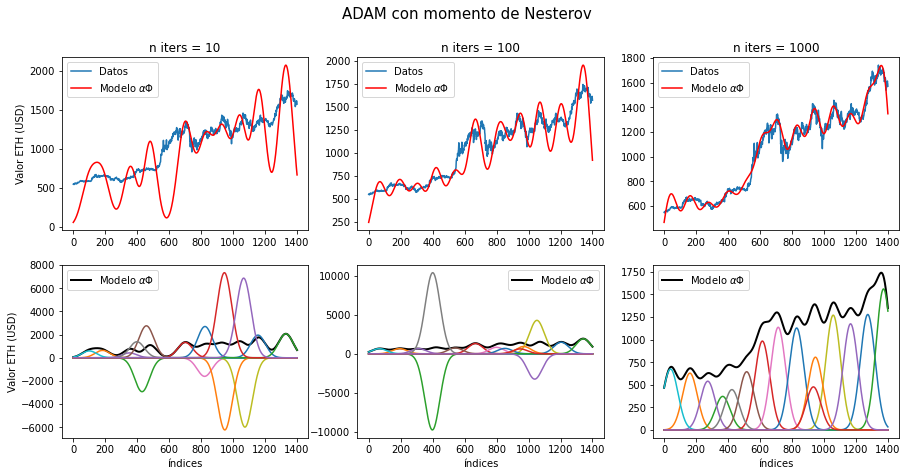

In [12]:
%%time

titulo = 'ADAM con momento de Nesterov'
parms_at_T = []
for T in n_iters:
    mu_hat, a_hat = ADAM(grad = grad_J, 
            grad_params= grad_params,
            x=x, y=y, 
            batch_size=100,
            lr=0.95, n_iter=T,
            nesterov=True)
    parms_at_T.append((mu_hat, a_hat))

# Graficas de los resultados
graficar_resultados(parms_at_T, titulo)